In [1]:
import pandas as pd
import numpy as np
from fastai.structured import *
from fastai.column_data import *
from sklearn import metrics
np.set_printoptions(threshold=50, edgeitems=20)

In [2]:
print(torch.cuda.current_device())
torch.cuda.set_device(1)

0


In [3]:
train = pd.read_csv('./datasets/ihm/train.csv')
test = pd.read_csv('./datasets/ihm/test.csv')
val = pd.read_csv('./datasets/ihm/val.csv')
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)
val = val.drop('Unnamed: 0', axis=1)

In [4]:
print(len(train[train['Mortality'] == 1]))
print(len(train[train['Mortality'] == 0]))

180592
1014121


In [5]:
def balance_dataset(df):
    split_set = []
    num_survived = 0
    num_died = 0
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
        if df_episode.iloc[0]['Mortality'] < 1:
            num_survived = num_survived +1
        else:
            num_died = num_died +1
    counter = 0
    for patient in split_set:
        if patient.iloc[0]['Mortality'] == 1 and num_died < num_survived:
            split_set.append(patient)
            counter = counter +1
            num_died = num_died +1
    print(num_died, num_survived)
    complete_data =  pd.DataFrame(columns=df.columns)
    for patient in split_set:
        complete_data = pd.concat([complete_data,patient])
    return complete_data




#train_balanced = balance_dataset(train)

In [6]:
print(len(train[train['Mortality'] == 1]))
print(len(train[train['Mortality'] == 0]))

180592
1014121


In [7]:
train_size = len(train)
train = train.append(val)


print(train_size)
print(len(train))
val_idx = list(range(train_size, len(train)))

1194713
1458046


In [8]:
cat_vars = ['Capillary refill rate', 'Glascow coma scale eye opening' ,'Glascow coma scale motor response','Glascow coma scale total', 'Glascow coma scale verbal response','Episode' ]


for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
for v in cat_vars: test[v] = test[v].astype('category').cat.as_ordered()

cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

print(cat_sz)

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

[('Capillary refill rate', 3), ('Glascow coma scale eye opening', 6), ('Glascow coma scale motor response', 7), ('Glascow coma scale total', 14), ('Glascow coma scale verbal response', 6), ('Episode', 17904)]


In [9]:
print(len(train[train['Mortality'] == 1]))
print(len(train[train['Mortality'] == 0]))

219588
1238458


In [37]:
df, y, nas, mapper = proc_df(train, 'Mortality', do_scale=True)
df_test, y_test, nas_test, mapper_test = proc_df(test, 'Mortality', do_scale=True, mapper=mapper, na_dict=nas) 

md = ColumnarModelData.from_data_frame('./datasets/ihm/', val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=256,
                                       test_df=df_test)

In [38]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [250,250,250], [0.2,0.2,0.2], y_range=[0.0,1.0])

In [39]:
pd.DataFrame(y.astype(np.float32))[0].unique()

array([0., 1.])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 48%|████▊     | 2246/4667 [00:14<00:16, 150.54it/s, loss=0.000157]

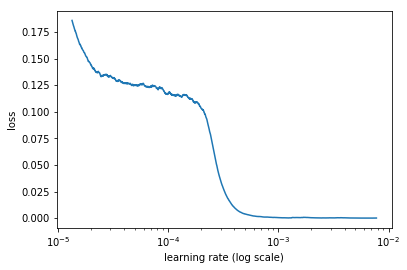

In [40]:
m.lr_find()
m.sched.plot(100)


In [59]:
lr = 0.0001


def roc_auc(preds, y):
    preds = np.exp(preds) #conv from logs
    exp = V(y).data.cpu().numpy() #predicted category ID
    #batch X num_classes
    bs = preds.shape[0] #batch size
    nclass = preds.shape[1] #size to determine length of Y one hot encoding
    y = np.zeros((bs, 2))

    y[np.arange(bs), exp.astype(np.int)] = 1 #one hot encode Ys
   
    return metrics.roc_auc_score(y, preds, average="micro")

def accuracy1(preds, targs):
    if np.array(targs.long()).max() == 1:
        print(preds, targs)
    #print ('preds: {}, {}'.format(preds.ceil() ,type(preds)))
    #print ('targs: {}, {}'.format(targs.ceil() ,type(targs)))
    return (preds.long()==targs.long()).float().mean()


In [60]:


m.fit(lr, 3, metrics=[roc_auc], cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

 12%|█▏        | 573/4667 [00:03<00:27, 150.42it/s, loss=1.07e-09]

Exception in thread Thread-30:
Traceback (most recent call last):
  File "/home/andreas/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/andreas/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/andreas/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



                                                                   
 1.3261e-06
 1.9189e-06
 1.4512e-06
 1.4194e-06
 1.5374e-06
 2.1069e-06
 1.8768e-06
 1.8918e-06
 2.1397e-06
 2.1216e-06
 2.1846e-06
 1.6267e-06
 2.6250e-06
 3.0393e-06
 3.5677e-06
 3.6104e-06
 2.6279e-06
 3.8529e-06
 3.5730e-06
 3.9520e-06
 3.9077e-06
 3.3011e-06
 3.5417e-06
 2.8840e-06
 2.0957e-06
 1.4887e-06
 1.6264e-06
 1.2602e-06
 6.6654e-07
 5.5792e-07
 1.8545e-06
 1.9235e-06
 5.7837e-07
 7.1325e-07
 6.6702e-07
 2.3659e-06
 2.3758e-06
 2.1658e-06
 2.8170e-06
 1.7883e-06
 8.8402e-07
 8.4884e-07
 2.5066e-06
 1.4213e-06
 8.6485e-07
 8.6676e-07
 1.0319e-06
 1.3723e-06
 1.3932e-06
 1.9360e-06
 1.0695e-06
 6.0899e-07
 5.5203e-07
 5.1160e-07
 8.4548e-07
 8.4495e-07
 4.1870e-07
 5.4306e-07
 4.6531e-07
 3.0941e-07
 3.5675e-07
 3.1045e-07
 2.4594e-07
 5.0477e-07
 2.3516e-07
 3.8842e-07
 1.7940e-07
 2.1801e-07
 2.1510e-07
 9.7814e-08
 7.8725e-08
 7.3735e-03
 7.4205e-03
 1.0408e-02
 9.2229e-03
 9.3235e-03
 1.5024e-11
 8.3178e

ValueError: DataFrame constructor not properly called!

In [ ]:


def split_test_set(df):
    split_set = []
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
    return split_set

test_split = split_test_set(df_test)

survived_correct = 0
survived_wrong = 0
died_correct = 0
died_wrong = 0
for patient in test_split:
    prediction = m.predict(patient).max()
    y_true = patient.iloc[0]['Mortality']
    if( y_true == 1 and y_true == prediction ):
        died_correct = died_correct +1
    elif y_true == 1:
        died_wrong = died_wrong +1
    elif y_true == prediction:
        survived_correct = survived_correct+1
    else: 
        survived_wrong = survived_wrong+1
print(survived_correct, survived_wrong)
print(died_correct, died_wrong)